# Session 1 - Normal Workflows

Let's activate our previously created environment and import BattMo into the kernel.

In [1]:
import Pkg
Pkg.activate("../") # Activates the environment in the current folder

using BattMo, GLMakie

  Activating project at `c:\Users\lorenah\Documents\Repositories\BattMo-workshop-2025-06-13`


### Part 1 - Create your own parameter sets

This part of the tutorial walks you through the process of creating and customizing your own parameter sets in BattMo.jl. Parameter sets define the physical and chemical properties of the battery system you're simulating. You can build them from scratch using model templates, modify them, and save them for future use.

##### Step 1 - Initiate a model setup

First, define the battery model configuration you'd like to use. This will serve as the template for generating your parameter set. BattMo includes several default setups to choose from.

In [2]:
model_settings = load_model_settings(; from_default_set = "P2D")
model_settings["SEIModel"] = "Bolay"

model_setup = LithiumIonBattery(; model_settings)

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


LithiumIonBattery("P2D Setup object for a lithium-ion model", {
    "SEIModel" => "Bolay"
    "RampUp" => "Sinusoidal"
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P2D"
}, true)

##### Step 2 - load an empty parameter set

Next, create an empty parameter dictionary based on your model setup. This will include all the required keys but without any values filled in.

In [3]:
empty_cell_parameter_set = load_cell_parameters(; from_model_template = model_setup)

{
    "Electrolyte" =>     {
        "TransferenceNumber" => 0.0
        "DiffusionCoefficient" => 0.0
        "IonicConductivity" => 0.0
        "Density" => 0.0
        "ChargeNumber" => 0.0
        "Concentration" => 0.0
    }
    "Cell" =>     {
        "ElectrodeGeometricSurfaceArea" => 0.0
        "Case" => ""
    }
    "PositiveElectrode" =>     {
        "ActiveMaterial" =>         {
            "ActivationEnergyOfDiffusion" => 0.0
            "NumberOfElectronsTransfered" => 0.0
            "StoichiometricCoefficientAtSOC0" => 0.0
            "OpenCircuitPotential" => 0.0
            "ReactionRateConstant" => 0.0
            "MassFraction" => 0.0
            "StoichiometricCoefficientAtSOC100" => 0.0
            "ActivationEnergyOfReaction" => 0.0
            "MaximumConcentration" => 0.0
            "VolumetricSurfaceArea" => 0.0
            "DiffusionCoefficient" => 0.0
            "ParticleRadius" => 0.0
            "Density" => 0.0
            "ElectronicConductivity" => 0

##### Step 3 - Save the empty set to a JSON file

You can now write this empty set to a JSON file. This file can be edited manually, shared, or used as a base for further customization.

In [4]:
file_path = "my_custom_parameters.json"
write_to_json_file(file_path, empty_cell_parameter_set)

Data successfully written to my_custom_parameters.json


##### Step 4 - Let BattMo help you fill the empty set

If you're unsure about what a specific parameter means or how it should be formatted, BattMo provides a helpful function to inspect any parameter.

In [5]:
print_parameter_info("OpenCircuitPotential")

ℹ️  Parameter Information
Parameter                     type                                    unit
--------------------------------------------------------------------------------
OpenCircuitPotential          String, Dict{String, Vector}, Real      V



The automatic validation when initiating the Simulation object can help you keep track of your progress on filling in the parameter values and find any values that are unrealistic.

In [6]:
cell_parameters = load_cell_parameters(; from_file_path= "my_custom_parameters.json")


sim = Simulation(model_setup, cell_parameters, load_cycling_protocol(;from_default_set= "CCDischarge"));

🔍 Validation of CellParameters failed with 48 issues:

──────────────────────────────────────────────────
──────────────────────────────────────────────────
Issue 1:
📍 Where:       [Electrolyte][TransferenceNumber]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.05
🛠  Issue:       Value is below the minimum allowed (0.05)

──────────────────────────────────────────────────
Issue 2:
📍 Where:       [Electrolyte][Density]
🔢 Provided:    0.0
🔑 Rule:        minimum = 100.0
🛠  Issue:       Value is below the minimum allowed (100.0)

──────────────────────────────────────────────────
Issue 3:
📍 Where:       [Electrolyte][ChargeNumber]
🔢 Provided:    0.0
🔑 Rule:        minimum = 1
🛠  Issue:       Value is below the minimum allowed (1)

──────────────────────────────────────────────────
Issue 4:
📍 Where:       [Electrolyte][Concentration]
🔢 Provided:    0.0
🔑 Rule:        minimum = 100
🛠  Issue:       Value is below the minimum allowed (100)

──────────────────────────────────────────────────
Iss

The same steps can be applied for creating cycling protocols and simulation settings. Now you know how you can create your own input files! The simplify the process of this workshop, we'll continue using the default parameter sets that BattMo provides. Let's use BattMo now to solve some fun and common problems!

## Part 2 - Electrode balancing

In this tutorial, we will study the effects that electrode thicknesses have over the power delivered by a cell. Power capability is usually determined from the
loss in capacity when cycling the cell at higher rates. We will compare the effects of thickness on the power delivery of a cell. Let's load some default parameter sets and model settings.

In [13]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020_calibrated.json")
cc_discharge_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json")

model_setup = LithiumIonBattery()

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


LithiumIonBattery("P2D Setup object for a lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P2D"
}, true)

We will change the thickness of the positive electrode, and evaluate the cell capacity at different CRates. Lets define the DRates to use and the range of thicknesses to explore.

In [24]:
d_rates = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 2.5, 3.0]
thicknesses = range(8.0e-5, 10.0e-5, length = 9)

8.0e-5:2.5e-6:0.0001

Now we loop through both DRates and thicknesses to run a simulation for each combination. For each simulation, we will calculate the discharge capacity, and store it for plotting.

In [33]:
power_rates = []
np_ratios = []

for thickness in thicknesses

	capacities = []
	
	cell_parameters["NegativeElectrode"]["ElectrodeCoating"]["Thickness"] = thickness
	n_to_p_ratio = compute_np_ratio(cell_parameters)
	push!(np_ratios, n_to_p_ratio)

	for d_rate in d_rates

		cc_discharge_protocol["DRate"] = d_rate
		sim = Simulation(model_setup, cell_parameters, cc_discharge_protocol)
		print("###### Simulation of thickness $thickness | d_rate $d_rate #########")
		output = solve(sim; end_report = false)

		if length(output[:states]) > 0 # if simulation is successful
			discharge_capacity = compute_discharge_capacity(output)
			push!(capacities, discharge_capacity)
		else
			push!(capacities, 0.0)
		end
	end
	push!(power_rates, (thickness = thickness, d_rates = d_rates, capacities = capacities, np_ratio = n_to_p_ratio))
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────

Now we plot capacities vs Drate at different thicknesses of the negative electrode:

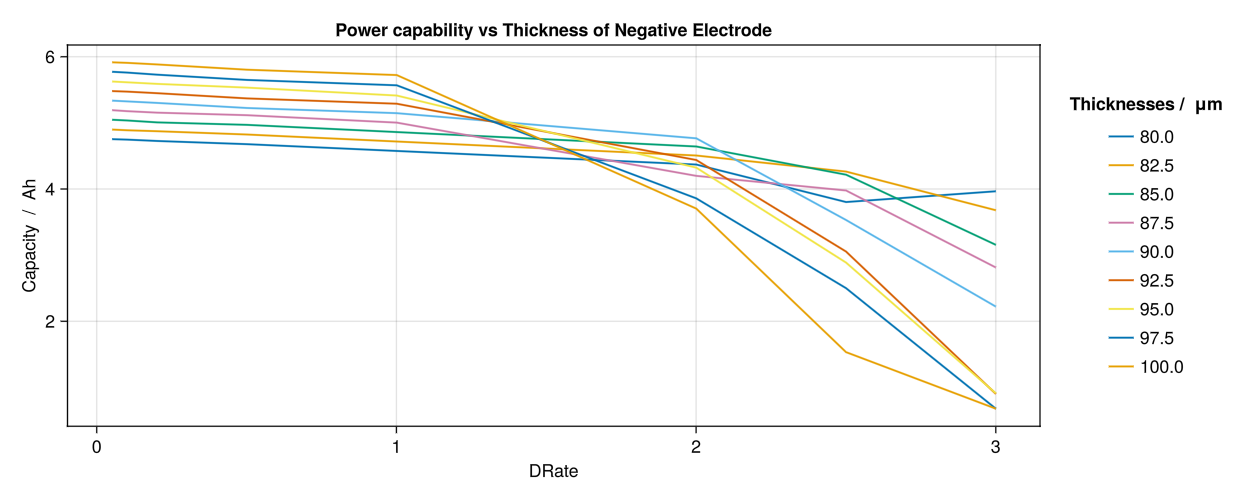

In [31]:
fig = Figure(size = (1000, 400))
ax = Axis(fig[1, 1], title = "Power capability vs Thickness of Negative Electrode",
          xlabel = "DRate", ylabel = "Capacity  /  Ah")

for experiment in power_rates
    label_str = lowercase(string(experiment.thickness*10^6))  # Scientific notation as string
    lines!(ax, experiment.d_rates, experiment.capacities, label = label_str)
end

fig[1, 2] = Legend(fig, ax, "Thicknesses /  μm", framevisible = false)
fig


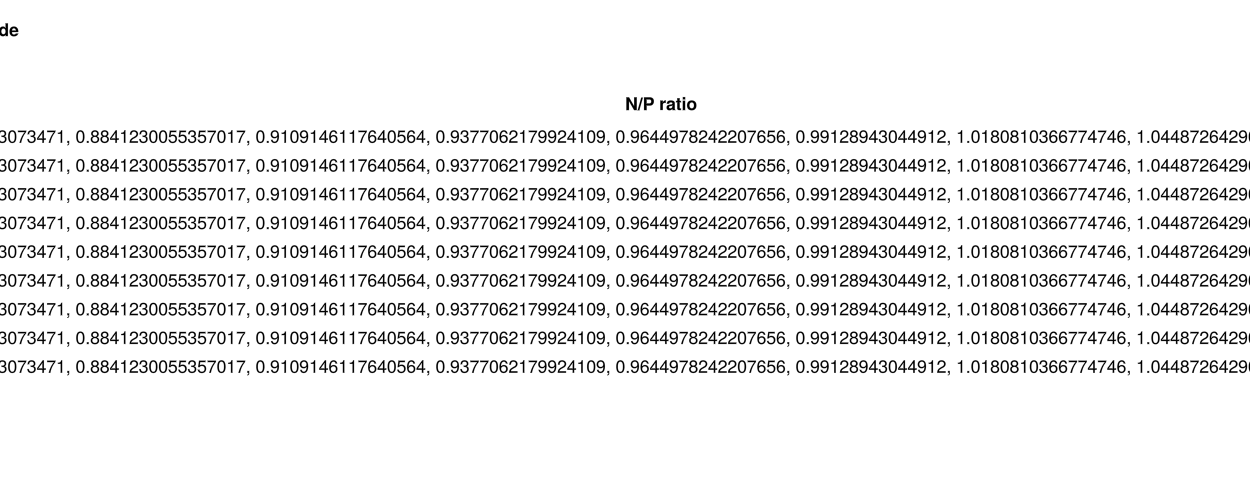

In [32]:
fig = Figure(size = (1000, 400))
ax = Axis(fig[1, 1], title = "Power capability vs Thickness of Negative Electrode",
          xlabel = "DRate", ylabel = "Capacity  /  Ah")

for experiment in power_rates
    label_str = lowercase(string(experiment.np_ratios))  # Scientific notation as string
    lines!(ax, experiment.d_rates, experiment.capacities, label = label_str)
end

fig[1, 2] = Legend(fig, ax, "N/P ratio", framevisible = false)
fig

## Part 3 - Rate capability

In this part we will compare the effect that the reaction rate values have on cell performance. Lets start again with loading some pre-defined cell parameters and cycling protocols.

In [ ]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020_calibrated.json")
cc_discharge_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json")

model_setup = LithiumIonBattery()

First lets see the effect that the reaction rate of the negative electrode has on cell performance. To do this, we simply loop through
a list of parameter values, carry a simulation for each value, store the outputs, and compare the voltage curves for every output.
We use the logarithm of the reaction rates to change their values by orders of magnitude.

In [ ]:
log_rate_start = -3.0
log_rate_stop = -13.0

outputs_rate = []
for r in range(log_rate_start, log_rate_stop, length = 10)
	cell_parameters["NegativeElectrode"]["ActiveMaterial"]["ReactionRateConstant"] = 10^r
	sim = Simulation(model_setup, cell_parameters, cycling_protocol)
	result = solve(sim; config_kwargs = (; end_report = false))
	push!(outputs_rate, (r = r, output = result))  # store r together with output
end

Now, plot the discharge curves for each reaction rate:

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], ylabel = "Voltage / V", xlabel = "Time / s", title = "Discharge curve")

for data in outputs_rate
	local t = [state[:Control][:Controller].time for state in data.output[:states]]
	local E = [state[:Control][:Phi][1] for state in data.output[:states]]
	lines!(ax, t, E, label = @sprintf("%.1e", 10^data.r))
end

fig[1, 2] = Legend(fig, ax, "Reaction rate", framevisible = false)
fig

Sweeping reaction rates result in interesting behavior of the cells voltage and capacity. High reaction rates have negligible influence 
on the cell voltage curve. However, values below 1e-10 result in a noticeable difference on the curves and the cell's capacity. 
This observations might be attributed to the interplay between Li+ diffusion and reaction processes. For high reaction rates, 
the limiting Li+ transport step might be diffusing Li+ from/to the electrodes. However, below a threshold value, the reaction kinetics 
becomes the bottleneck step in Li+ transport, thus contributing significantly to the cell's overpotential. 

Lets now see the effect that the diffusion coefficient of the positive electrode has on cell performance. We first set the reaction rate 
to the original value in the parameter set, and then follow the same procedure as above.

In [ ]:
cell_parameters["NegativeElectrode"]["ActiveMaterial"]["ReactionRateConstant"] = 1.0e-13

log_D_start = -10.0
log_D_stop = -15.0

outputs_diff = []

for d in range(log_D_start, log_D_stop, length = 10)
	cell_parameters["PositiveElectrode"]["ActiveMaterial"]["DiffusionCoefficient"] = 10^d
	sim = Simulation(model_setup, cell_parameters, cycling_protocol)
	result = solve(sim; config_kwargs = (; end_report = false))
	push!(outputs_diff, (d = d, output = result))  # store r together with output
end


fig1 = Figure()
ax1 = Axis(fig1[1, 1], ylabel = "Voltage / V", xlabel = "Time / s", title = "Discharge curve")

for data in outputs_diff
	if length(data.output[:states]) > 0 #if simulation is successful
		local t = [state[:Control][:Controller].time for state in data.output[:states]]
		local E = [state[:Control][:Phi][1] for state in data.output[:states]]
		lines!(ax1, t, E, label = @sprintf("%.1e", 10^data.d))
	end
end

fig1[1, 2] = Legend(fig1, ax1, "Diffusion Coefficient", framevisible = false)
fig1

Diffusion coefficients, just as reaction rates, have also a non-linear effect on the cells voltage and capacity. Diffusion coefficients
down to 5e-14  have negligible influence on the cell voltage curve. However, as the coefficients fall below 5e-14 they start to influence
the curves and the cell's capacity in a noticeable way. The effect becomes more pronounced at lower values. As with reaction rates,  
these observations might originate from the interplay between Li+ diffusion and reaction processes, where the cell's overpotential responds
to the transport limiting step.